# Sentiment Analysis
## M Rifat Bagus A (20/456371/TK/50501)
## Nismara Chandra H (20/456371/TK/50501)

Data set yang digunakan merupakan dataset review-review film yang ada pada IMDB.

Link Dataset: https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format?datasetId=429163&sortBy=voteCount

##**Importing Libraries** 

In [1]:
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
plt.style.use('ggplot')
import io
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 28.8 MB/s 
     |████████████████████████████████| 6.6 MB 56.3 MB/s 
     |████████████████████████████████| 163 kB 48.3 MB/s 


In [3]:
import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch
import transformers

##**Read Dataset**

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
df = pd.read_csv('/content/gdrive/MyDrive/Dataset/Train.csv')
dfeva=pd.read_csv('/content/gdrive/MyDrive/Dataset/Valid.csv')

In [6]:
df.isna().sum()

text     0
label    0
dtype: int64

In [7]:
df.head(10)


text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1
5  A terrible movie as everyone has said. What ma...      0
6  Finally watched this shocking movie last night...      1
7  I caught this film on AZN on cable. It sounded...      0
8  It may be the remake of 1987 Autumn's Tale aft...      1
9  My Super Ex Girlfriend turned out to be a plea...      1

In [8]:
dfeva.head(10)

text  label
0  It's been about 14 years since Sharon Stone aw...      0
1  someone needed to make a car payment... this i...      0
2  The Guidelines state that a comment must conta...      0
3  This movie is a muddled mish-mash of clichés f...      0
4  Before Stan Laurel became the smaller half of ...      0
5  This is the best movie I've ever seen! <br /><...      1
6  The morbid Catholic writer Gerard Reve (Jeroen...      1
7  "Semana Santa" or "Angel Of Death" is a very w...      0
8  Somebody mastered the difficult task of mergin...      1
9  Why did I waste 1.5 hours of my life watching ...      0

In [9]:
df = df.rename(columns={'text':'statement','label':'sentiment'})
dfeva = dfeva.rename(columns={'text':'statement','label':'sentiment'})

In [10]:
df.head()

statement  sentiment
0  I grew up (b. 1965) watching and loving the Th...          0
1  When I put this movie in my DVD player, and sa...          0
2  Why do people who do not know what a particula...          0
3  Even though I have great interest in Biblical ...          0
4  Im a die hard Dads Army fan and nothing will e...          1

In [11]:
dfeva.head()

statement  sentiment
0  It's been about 14 years since Sharon Stone aw...          0
1  someone needed to make a car payment... this i...          0
2  The Guidelines state that a comment must conta...          0
3  This movie is a muddled mish-mash of clichés f...          0
4  Before Stan Laurel became the smaller half of ...          0

# Basic Data Cleaning

In [12]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

### Menghilangkan url, html tag, stopword, etc.

In [13]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['statement']=df['statement'].apply(denoise_text)
dfeva['statement']=dfeva['statement'].apply(denoise_text)

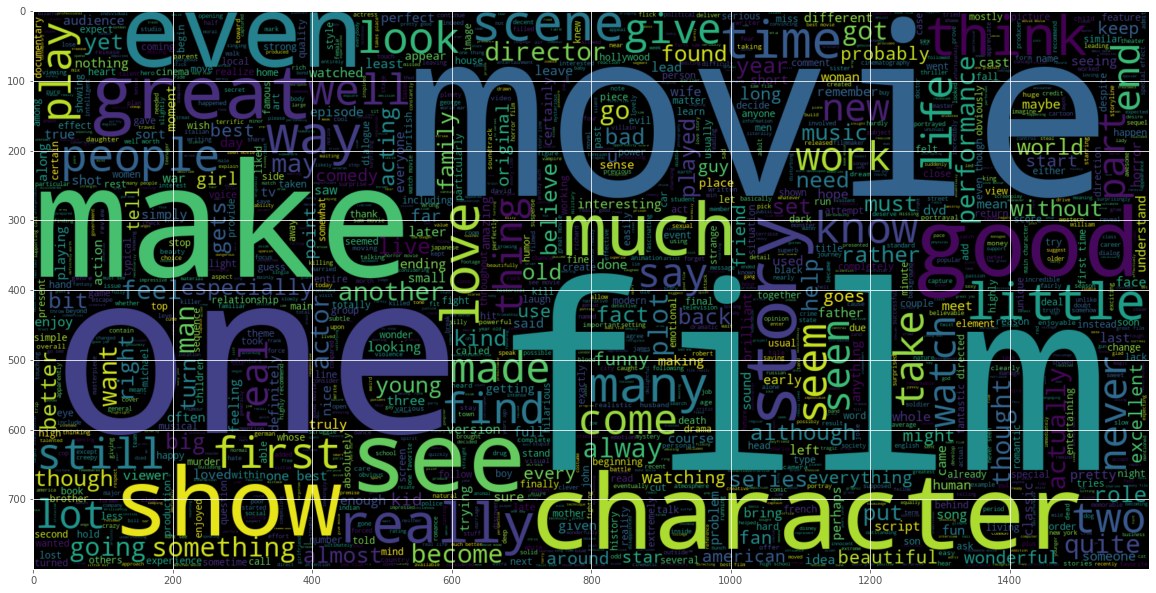

In [14]:
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 1].statement))
plt.imshow(wc , interpolation = 'bilinear')

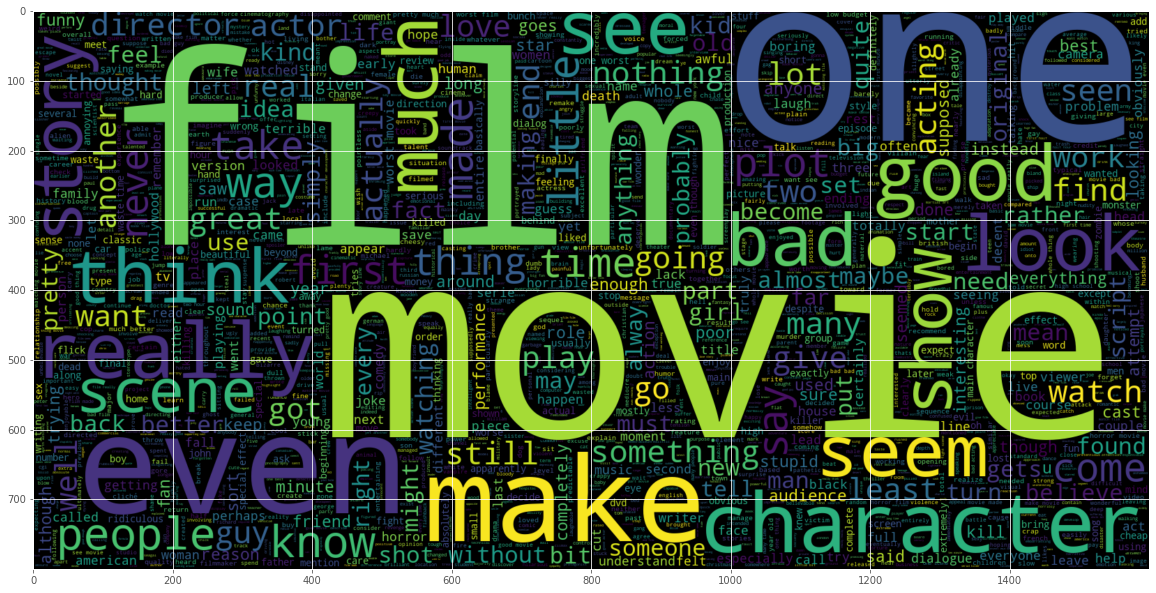

In [38]:
plt.figure(figsize = (20,20)) # Negative Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].statement))
plt.imshow(wc , interpolation = 'bilinear')

## **Build Model**

In [15]:
!pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Membuat label serta dataframe untuk train dan evaluasi model

In [16]:
def making_label(st):
    if(st== 1):
        return 1
    elif(st== 0):
        return 0
    
df['label'] = df['sentiment'].apply(making_label)
dfeva['label'] = dfeva['sentiment'].apply(making_label)
print(df.shape)

(40000, 3)


In [17]:
train_df = pd.DataFrame({
    'text': df['statement'][:1500].replace(r'\n', ' ', regex=True),
    'label': df['label'][:1500]
})

eval_df = pd.DataFrame({
    'text': dfeva['statement'][-400:].replace(r'\n', ' ', regex=True),
    'label':dfeva['label'][-400:]
})


In [18]:
train_df.head()

text  label
0  grew watching loving mates school played lunch...      0
1  put movie dvd sat coke hoping movie would cont...      0
2  people know particular time past like feel nee...      0
3  even though great interest biblical bored deat...      0
4  im die hard dads army fan nothing ever change ...      1

### Pendifinisian Model
Model dibuat menggunakan  model yang diambil dari library simpletransformer. Model yang diimport berupa model yang sudah siap untuk di train. Model yang digunakan dari simpletransformer juga sudah include dengan tokenizer.

In [19]:
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 250 kB 24.6 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 9.2 MB 61.9 MB/s 
     |████████████████████████████████| 1.3 MB 59.3 MB/s 
     |████████████████████████████████| 1.9 MB 57.6 MB/s 
     |████████████████████████████████| 432 kB 60.2 MB/s 
     |████████████████████████████████| 162 kB 69.2 MB/s 
     |████████████████████████████████| 182 kB 68.4 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 162 kB 71.8 MB/s 
     |████████████████████████████████| 158 kB 78.4 MB/s 
     |████████████████████████████████| 157 kB 77.1 MB/s 
     |████████████████████████████████| 157 kB 60.1 MB/s 
     |████████████████████████████████| 157 kB 45.2 MB/s 
     |████████████████████████████████| 157 kB 65.1 MB/s 
     |█████████████████████████████

In [20]:
from simpletransformers.classification import ClassificationModel
import torch


cuda_available = torch.cuda.is_available()

# Create a TransformerModel
model = ClassificationModel('bert', 'bert-base-cased', num_labels=2, args={'reprocess_input_data': True, 'overwrite_output_dir': True, "num_train_epochs":6 },use_cuda=cuda_available)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [21]:
model.train_model(train_df)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/188 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/188 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/188 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/188 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/188 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/188 [00:00<?, ?it/s]

(1128, 0.24356408599526325)

In [22]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1455: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/400 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

## **Model Evaluation**

In [23]:
result

{'mcc': 0.6300028067652467,
 'tp': 169,
 'tn': 156,
 'fp': 26,
 'fn': 49,
 'auroc': 0.8985532815808044,
 'auprc': 0.9145270187179306,
 'eval_loss': 1.2759924125671387}

In [24]:
model_outputs
lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

In [25]:
true = eval_df['label'].tolist()
predicted = lst

In [26]:
import sklearn
mat = sklearn.metrics.confusion_matrix(true , predicted)
mat

array([[156,  26],
       [ 49, 169]])

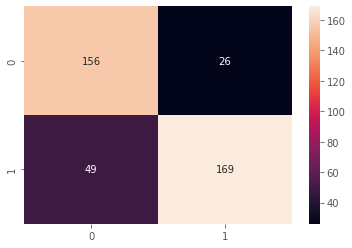

In [27]:
df_cm = pd.DataFrame(mat, range(2), range(2))

sns.heatmap(df_cm, annot=True, fmt='g') 
plt.show()

In [28]:
sklearn.metrics.accuracy_score(true,predicted)

0.8125

In [29]:
sklearn.metrics.classification_report(true,predicted,target_names=['positive','negative'],output_dict = True)

{'positive': {'precision': 0.7609756097560976,
  'recall': 0.8571428571428571,
  'f1-score': 0.806201550387597,
  'support': 182},
 'negative': {'precision': 0.8666666666666667,
  'recall': 0.7752293577981652,
  'f1-score': 0.8184019370460048,
  'support': 218},
 'accuracy': 0.8125,
 'macro avg': {'precision': 0.8138211382113821,
  'recall': 0.8161861074705111,
  'f1-score': 0.812301743716801,
  'support': 400},
 'weighted avg': {'precision': 0.8185772357723577,
  'recall': 0.8125,
  'f1-score': 0.8128507611164292,
  'support': 400}}

## **Prediksi Model menggunakan Test Dataset**

In [30]:
dftest = pd.read_csv('/content/gdrive/MyDrive/Dataset/Test.csv')

In [31]:
dfsmalltest =dftest.head(100)

In [32]:
def get_result(statement):
    result = model.predict([statement])
    pos = np.where(result[1][0] == np.amax(result[1][0]))
    pos = int(pos[0])
    sentiment_dict = {1:'positive',0:'negative'}
    
   
    return sentiment_dict[pos]

In [33]:
prediction = []

In [34]:
for value in dfsmalltest['text']:
   x = get_result(value)
   if x == 'positive' :
    prediction.append('positive')
   else:
    prediction.append('negative')
   print(x)
   



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


In [35]:
dfsmalltest['prediction'] = prediction

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
dfsmalltest.head(10)

text  label prediction
0  I always wrote this series off as being a comp...      0   negative
1  1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...      0   positive
2  This movie was so poorly written and directed ...      0   negative
3  The most interesting thing about Miryang (Secr...      1   positive
4  when i first read about "berlin am meer" i did...      0   negative
5  I saw this film on September 1st, 2005 in Indi...      1   positive
6  I saw a screening of this movie last night. I ...      0   negative
7  William Hurt may not be an American matinee id...      1   positive
8  IT IS A PIECE OF CRAP! not funny at all. durin...      0   negative
9  I'M BOUT IT(1997)<br /><br />Developed & publi...      0   positive

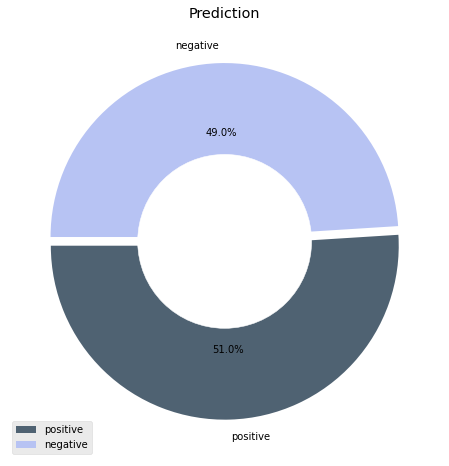

In [37]:
plt.figure(figsize=(12,8))
plt.title("Prediction")
circle = plt.Circle((0, 0), 0.5, color='white')
g = plt.pie(dfsmalltest.prediction.value_counts(), explode=(0.025,0.025),  labels=['positive','negative'], colors=['#4F6272', '#B7C3F3'],autopct='%1.1f%%', startangle=180);
plt.legend()
p = plt.gcf()
p.gca().add_artist(circle)
plt.show()

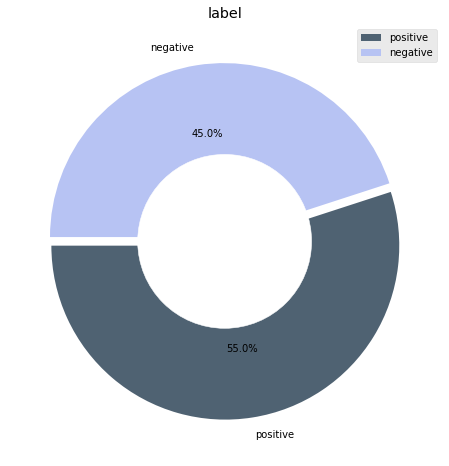

In [39]:
plt.figure(figsize=(12,8))
plt.title("label")
circle = plt.Circle((0, 0), 0.5, color='white')
g = plt.pie(dfsmalltest.label.value_counts(), explode=(0.025,0.025),  labels=['positive','negative'], colors=['#4F6272', '#B7C3F3'],autopct='%1.1f%%', startangle=180);
plt.legend()
p = plt.gcf()
p.gca().add_artist(circle)
plt.show()